In [41]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

# Transformation of time series into supervision problems

Time series data needs to be prepared before training a supervised learning model (such as LSTM neural network). For example, a unary time series is represented as an observation vector:

```
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

```

The supervised learning algorithm requires data to be provided as a set of samples, where each sample has an input component X and an output component y. The model will learn how to map input to output from the provided examples.


The time series must be converted into samples with input and output components .  For a univariate time series problem that is interested in one-step forecasting, you can use the observations at the previous time point as input and the observations at the current time point as the output. For example, the above 10-step univariate sequence can be expressed as a supervised learning problem, the input is 3 time steps, and the output is 1 time step, as shown below:

X *******   Y

===============
 
[1, 2, 3],  [4]

[2, 3, 4],  [5]

[3, 4, 5],  [6]

In [42]:
# Google Drive Root Path
# root_path = '/content/drive/MyDrive/Datasets_For_Working/Bitcoin_2015-2021-30-Oct-2021/3_pull.csv'

# Local Machine Root Path
# root_path = './input/btc_ohlc_Oct_2015_to_Oct_2021.csv'

# Kaggle Root Path
#root_path = '/kaggle/input/bitcoin-historic-prices-from-oct2015-to-oct2021/btc_ohlc_Oct_2015_to_Oct_2021.csv'
root_path = '/content/BTC15_21.csv'


# btc_input_df = pd.read_csv(root_path, nrows=500)
btc_input_df = pd.read_csv(root_path)
btc_input_df.tail()

,time,low,high,open,close,volume
3113271,2015-10-27 00:04:00,287.07,287.07,287.07,287.07,0.08610
3113272,2015-10-27 00:03:00,287.08,287.09,287.08,287.09,0.55440
3113273,2015-10-27 00:02:00,286.89,287.10,287.10,286.89,72.40320
3113274,2015-10-27 00:01:00,287.09,287.09,287.09,287.09,0.82276
3113275,2015-10-27 00:00:00,287.10,287.10,287.10,287.10,0.53620


In [43]:
btc_input_df.shape

(3113276, 6)

In [44]:
btc_input_df.describe()

,low,high,open,close,volume
count,3.113276e+06,3.113276e+06,3.113276e+06,3.113276e+06,3.113276e+06
mean,1.152825e+04,1.154230e+04,1.153537e+04,1.153541e+04,9.689568e+00
std,1.490292e+04,1.492446e+04,1.491374e+04,1.491379e+04,2.239875e+01
min,6.000000e-02,6.000000e-02,6.000000e-02,6.000000e-02,1.000000e-08
25%,1.849558e+03,1.850000e+03,1.849925e+03,1.849980e+03,1.331197e+00
50%,7.099990e+03,7.105000e+03,7.102045e+03,7.102060e+03,3.707298e+00
75%,1.067558e+04,1.068550e+04,1.068027e+04,1.068040e+04,9.761575e+00
max,6.690000e+04,6.699900e+04,6.694122e+04,6.694122e+04,1.549613e+03


In [45]:
btc_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113276 entries, 0 to 3113275
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   time    object 
 1   low     float64
 2   high    float64
 3   open    float64
 4   close   float64
 5   volume  float64
dtypes: float64(5), object(1)
memory usage: 142.5+ MB


# Convert 'time' column from object dtype to datetime dtype

From above I can see that the 'time' column is being treated as an object rather than as dates. To fix this, I will use the (pd.to_datetime() function which converts the arguments to dates.

In [46]:
btc_input_df_datetype = btc_input_df.astype({'time': 'datetime64'})

In [47]:
btc_input_df_datetype.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113276 entries, 0 to 3113275
Data columns (total 6 columns):
 #   Column  Dtype         
---  ------  -----         
 0   time    datetime64[ns]
 1   low     float64       
 2   high    float64       
 3   open    float64       
 4   close   float64       
 5   volume  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 142.5 MB


In [48]:
print('Null Values:',btc_input_df_datetype.isnull().values.sum())
print('If any NA values:', btc_input_df_datetype.isnull().values.any())

Null Values: 0
If any NA values: False


In [49]:
btc_input_df_datetype.tail()

,time,low,high,open,close,volume
3113271,2015-10-27 00:04:00,287.07,287.07,287.07,287.07,0.08610
3113272,2015-10-27 00:03:00,287.08,287.09,287.08,287.09,0.55440
3113273,2015-10-27 00:02:00,286.89,287.10,287.10,286.89,72.40320
3113274,2015-10-27 00:01:00,287.09,287.09,287.09,287.09,0.82276
3113275,2015-10-27 00:00:00,287.10,287.10,287.10,287.10,0.53620


In [50]:
btc_input_df_datetype.head()

,time,low,high,open,close,volume
0,2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079
1,2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357
2,2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848
3,2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070
4,2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128


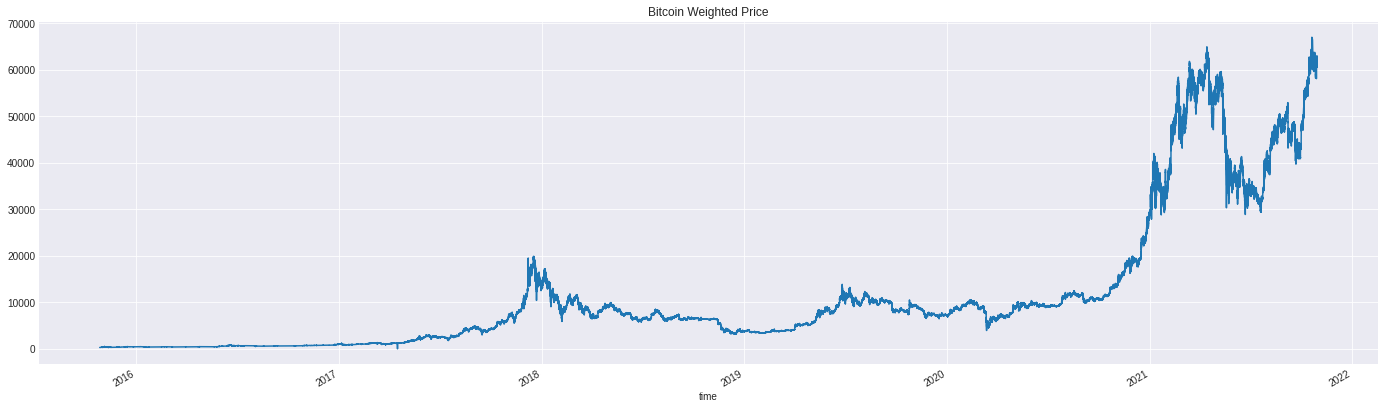

In [51]:
btc_input_df_datetype.set_index("time").close.plot(figsize=(24,7), title="Bitcoin Weighted Price")

# Lag Plot

Lag plot are used to observe the autocorrelation. These are crucial when we try to correct the trend and stationarity and we have to use smoothing functions. Lag plot helps us to understand the data better.

No handles with labels found to put in legend.


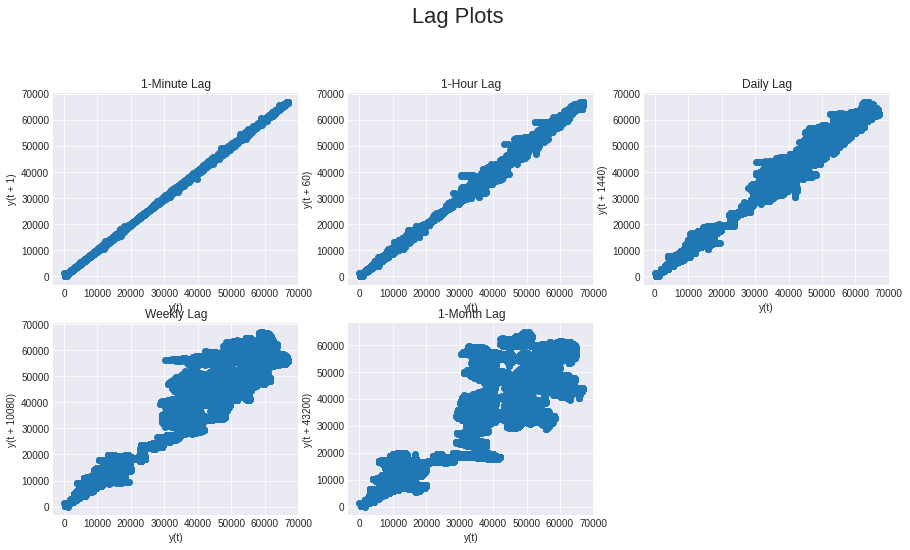

In [52]:
plt.figure(figsize=(15,12))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=10080) #weekly lag
plt.title('Weekly Lag')

plt.subplot(3,3,5)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=43200) #month lag
plt.title('1-Month Lag')

plt.legend()
plt.show()

We can see that there is a positive correlation for minute, hour and daily lag plots. 

Correlation decreases drastically with Weekly Lag and absolutely no correlation for month lag plots.

It makes sense to re-sample our data atmost at the Daily level, thereby preserving the autocorrelation as well.

# Making data ready for LSTM - pd.to_datetime(unit='s) and then groupby('date')

## pd.to_datetime unit='s'

The unit of the arg (D,s,ms,us,ns) denote the unit, which is an integer or float number. This will be based off the origin. Example, with unit=’ms’ and origin=’unix’ (the default), this would calculate the number of milliseconds to the unix epoch start.

Say you pass an int as your arg (like 20203939), with unit, you’ll be able specify what unit your int is away from the origin. In the example here, if we set unit=’s’, this means pandas will interpret 20203939 as 20,203,939 seconds away from the origin. Available units are [D,s,ms,us,ns]. 
[Source](https://www.dataindependent.com/pandas/pandas-to-datetime/)

In [53]:
btc_input_df_datetype['date'] = pd.to_datetime(btc_input_df_datetype['time'],unit='s').dt.date

display(btc_input_df_datetype.head())

group = btc_input_df_datetype.groupby('date')

btc_closing_price_groupby_date = group['close'].mean()

,time,low,high,open,close,volume,date
0,2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079,2021-10-30
1,2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357,2021-10-30
2,2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848,2021-10-30
3,2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070,2021-10-30
4,2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128,2021-10-30


In [54]:
display(btc_closing_price_groupby_date.head(10))

print("Length of btc_closing_price_groupby_date :", len(btc_closing_price_groupby_date))

date
2015-10-27    292.887484
2015-10-28    301.991834
2015-10-29    310.537530
2015-10-30    326.665808
2015-10-31    323.877132
2015-11-01    319.527295
2015-11-02    339.226860
2015-11-03    386.773759
2015-11-04    450.035105
2015-11-05    400.249521
Name: close, dtype: float64

Length of btc_closing_price_groupby_date : 2196


# Train Test Split

In [55]:
prediction_days = 270

# Set Train data to be uplo ( Total data length - prediction_days )
df_train= btc_closing_price_groupby_date[:len(btc_closing_price_groupby_date)-prediction_days].values.reshape(-1,1)


# Set Test data to be the last prediction_days (or 60 days in this case)
df_test= btc_closing_price_groupby_date[len(btc_closing_price_groupby_date)-prediction_days:].values.reshape(-1,1)

In [56]:
df_test.shape


(270, 1)

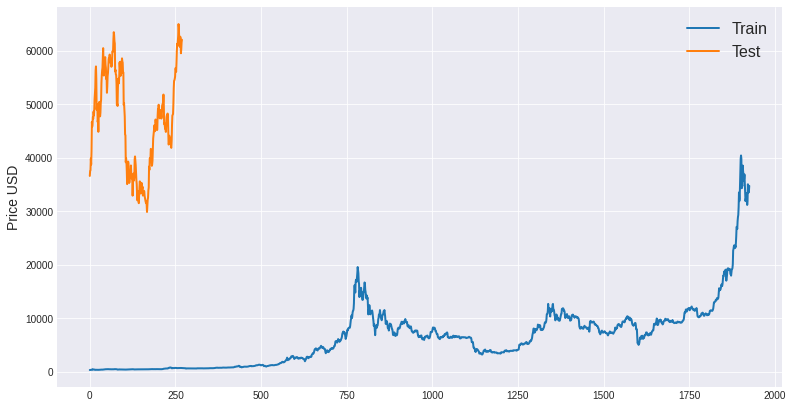

In [57]:
chosen_col = 'Close'

fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(df_train, label='Train', linewidth=2)
ax.plot(df_test, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

# Mix Max Scaling of Data post Train-Test Split

Scaling must be done after the data has been split into training and test sets — with each being scaled separately. 

A common mistake when first using the LSTM is to first normalize the data before splitting the data.

The reason this is erroneous is that the normalization technique will use data from the test sets as a reference point when scaling the data as a whole. This will inadvertently influence the values of the training data, essentially resulting in data leakage from the test sets.


In [58]:
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

# Dataset Generator for LSTM

We will frame the problem to take a window of the last so many number of days of data to predict the current days data.

To achieve this, we will define a new function named `dataset_generator_lstm()` that will split the input sequence into windows of data appropriate for fitting a supervised learning model, like an LSTM


For example, if the sequence was:

1, 2, 3, 4, 5, 6, 7, 8, 9, 10


Then the samples for training the model will look like:

```

Input 				| Output
1, 2, 3, 4, 5 		6
2, 3, 4, 5, 6 		7
3, 4, 5, 6, 7 		8

```

LSTMs expect each sample in the dataset to have two dimensions; the first is the number of time steps (in the above case it is 5), and the second is the number of observations per time step (in this case it is 1).

Because it is a regression type problem, we will use a linear activation function in the output layer and optimize the mean squared error loss function. We will also evaluate the model using the mean squared error (MAE) metric.

## Define look_back period

A “lookback period” defines how many previous timesteps are used in order to predict the subsequent timestep. 

For example if I set the lookback period is to 5, that that means that I am using the time steps at t-4, t-3, t-2, t-1, and t to predict the value at time t+1.

For my case below, I will be using a one-step prediction model.

### Lookback period


```py

lookback = 5

X_train, Y_train = dataset_generator_lstm(train, lookback)

X_val, Y_val = dataset_generator_lstm(val, lookback)

```

### Quick note on Python slice notation for slicing an array

- [1:5] is equivalent to "from 1 to 5" (5 not included)

- [1:] is equivalent to "1 to end"

- [len(a):] is equivalent to "from length of a to end"

In the below function I will generate the train_X array and train_y array for feeding into the LSTM

In [59]:
def dataset_generator_lstm(dataset, look_back=5):
    # A “lookback period” defines the window-size of how many
    # previous timesteps are used in order to predict
    # the subsequent timestep. 
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0]) # this is the label or actual y-value
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(scaled_train)

testX, testY = dataset_generator_lstm(scaled_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testY: ", testX.shape)
print("testY", testY.shape)

trainX:  (1921, 5)
trainY:  (1921,)
testY:  (265, 5)
testY (265,)


In [60]:
print("trainX: ", trainX)
# print("trainY: ", trainY)
# print("testY: ", testX)
# print("testY", testY)

trainX:  [[0.00000000e+00 2.27009727e-04 4.40089877e-04 8.42235637e-04
  7.72702238e-04]
 [2.27009727e-04 4.40089877e-04 8.42235637e-04 7.72702238e-04
  6.64242498e-04]
 [4.40089877e-04 8.42235637e-04 7.72702238e-04 6.64242498e-04
  1.15543548e-03]
 ...
 [7.90547374e-01 7.69489487e-01 7.85587323e-01 8.65716839e-01
  8.41930313e-01]
 [7.69489487e-01 7.85587323e-01 8.65716839e-01 8.41930313e-01
  8.26791420e-01]
 [7.85587323e-01 8.65716839e-01 8.41930313e-01 8.26791420e-01
  8.33183959e-01]]


# For LSTM I need to reshape input to be a 3D Tensor of [samples, time steps, features]

    X = numpy.reshape(dataX, (len(dataX), seq_length, 1))

**Samples** - This is the len(dataX), or the amount of data points you have.

**Time steps** - A sample contains multiple time steps, that is, the width of the sliding window (according to the above example, the time step is 3). Note here that it is distinguished from the sliding step of the sliding window. This is equivalent to the amount of time steps you run your recurrent neural network. If you want your network to have memory of 60 characters, this number should be 60. For this notebook, I am using the window-size to be 5.

**Features** - this is the amount of features in every time step. If you are processing pictures, this is the amount of pixels. In this case I have 1 feature (the price of Bitcoin) per time step.

 ### According to the documentation and the source code, the Keras LSTM input data must be in the form: [batch_size, timesteps, input_dim].

 In Keras, the number of time steps is equal to the number of LSTM cells. This is what the word “time steps” means in the 3D tensor of the shape [batch_size, timesteps, input_dim].


### So to emphasize again, the input to every LSTM layer must be three-dimensional.

The three dimensions of this input are:

Samples. One sequence is one sample. A batch is comprised of one or more samples.

Time Steps. One time step is one point of observation in the sample.

Features. One feature is one observation at a time step.

This means that the input layer expects a 3D array of data when fitting the model and when making predictions, even if specific dimensions of the array contain a single value, e.g. one sample or one feature.

When defining the input layer of your LSTM network, the network assumes you have 1 or more samples and requires that you specify the number of time steps and the number of features. You can do this by specifying a tuple to the “input_shape” argument.

-----------------------

### Example of LSTM With Single Input Sample where you have one sequence of multiple time steps and one feature.

For example, this could be a sequence of 10 values:

```
0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0

```

1. We can define this sequence of numbers as a NumPy array.

2. We can then use the reshape() function on the NumPy array to reshape this one-dimensional array into a three-dimensional array with 1 sample, 10 time steps, and 1 feature at each time step.

The reshape() function when called on an array takes one argument which is a tuple defining the new shape of the array. We cannot pass in any tuple of numbers; the reshape must evenly reorganize the data in the array.

3. Once reshaped, we can print the new shape of the array.

Putting all of this together, the complete example is listed below.

```py
from numpy import array
data = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
data = data.reshape((1, 10, 1))
print(data.shape)

```
Running the example prints the new 3D shape of the single sample.

```
(1, 10, 1)

```
This data is now ready to be used as input (X) to the LSTM with an input_shape of (10, 1).

```py
model = Sequential()
model.add(LSTM(32, input_shape=(10, 1)))
model.add(Dense(1))

```

----------------------------------

-------------------------------

# For LSTM Reshape input ( trainX and testX ) to be 3-D of [samples, time steps, features]

### First check the current shape of trainX and testX

In [61]:
print(trainX.shape)
print(testX.shape)

(1921, 5)
(265, 5)


### And now reshape trainX and testX 

In [62]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (1921, 5, 1)
Shape of testX:  (265, 5, 1)


In [63]:
print("trainX: ", trainX)
print(" ********** ")
print("testX: ", testX)

trainX:  [[[0.00000000e+00]
  [2.27009727e-04]
  [4.40089877e-04]
  [8.42235637e-04]
  [7.72702238e-04]]

 [[2.27009727e-04]
  [4.40089877e-04]
  [8.42235637e-04]
  [7.72702238e-04]
  [6.64242498e-04]]

 [[4.40089877e-04]
  [8.42235637e-04]
  [7.72702238e-04]
  [6.64242498e-04]
  [1.15543548e-03]]

 ...

 [[7.90547374e-01]
  [7.69489487e-01]
  [7.85587323e-01]
  [8.65716839e-01]
  [8.41930313e-01]]

 [[7.69489487e-01]
  [7.85587323e-01]
  [8.65716839e-01]
  [8.41930313e-01]
  [8.26791420e-01]]

 [[7.85587323e-01]
  [8.65716839e-01]
  [8.41930313e-01]
  [8.26791420e-01]
  [8.33183959e-01]]]
 ********** 
testX:  [[[0.19179697]
  [0.21923019]
  [0.22167878]
  [0.28410573]
  [0.25272753]]

 [[0.21923019]
  [0.22167878]
  [0.28410573]
  [0.25272753]
  [0.32338502]]

 [[0.22167878]
  [0.28410573]
  [0.25272753]
  [0.32338502]
  [0.47973851]]

 ...

 [[0.88965005]
  [0.87887827]
  [0.93299957]
  [0.92426505]
  [0.84468861]]

 [[0.87887827]
  [0.93299957]
  [0.92426505]
  [0.84468861]
  [0.865

## Let’s take a look at the normalized window for trainX.

```
[[[0.00000000e+00]
  [1.44159882e-04]
  [2.79473948e-04]
  [5.34851927e-04]
  [4.90695552e-04]]

 [[1.44159882e-04]
  [2.79473948e-04]
  [5.34851927e-04]
  [4.90695552e-04]
  [4.21819458e-04]]

 [[2.79473948e-04]
  [5.34851927e-04]
  [4.90695552e-04]
  [4.21819458e-04]
  [7.33745838e-04]]... ]

```
Above are the first three entries. We can see that the five time steps immediately prior to the one we are trying to predict move in a stepwise motion.

Consider the last value of the first window which is => 4.90695552e-04

# LSTM (Long Short-Term Memory) Mechanism

The Long Short-Term Memory, or LSTM, is a recurrent neural network that is comprised of internal gates.

Unlike other recurrent neural networks, the network’s internal gates allow the model to be trained successfully using backpropagation through time, or BPTT, and avoid the vanishing gradients problem.

In the Keras deep learning library, LSTM layers can be created using the LSTM() class.

Creating a layer of LSTM memory units allows you to specify the number of memory units within the layer.

Each unit or cell within the layer has an internal cell state, often abbreviated as “c“, and outputs a hidden state, often abbreviated as “h“.

The Keras API allows you to access these data, which can be useful or even required when developing sophisticated recurrent neural network architectures, such as the encoder-decoder model.


## `input_shape` of LSTM Model - `input_shape` is supposed to be (timesteps, n_features).

    input_shape = (95000,360)

Keras LSTM takes and input with shape of (n_examples, n_times, n_features) and your layers input has to have this shape

To give you an example: if I'm observing the amount of rain and the temperature each hour for 24h in order to predict the weather (1 = good, 0 = bad), and I do that for 365 days, I will have 365 samples, each of which will have 24 timesteps, and 2 variables (one for rain, one for temperature), so my input is going to have the shape (365, 24, 2), and input_shape = (24, 2)


## `return_sequences=True`

The original LSTM model is comprised of a single hidden LSTM layer followed by a standard feedforward output layer.

The Stacked LSTM is an extension to this model that has multiple hidden LSTM layers where each layer contains multiple memory cells.

You must set return_sequences=True when stacking LSTM layers so that the second LSTM layer has a compatible n-dimensional sequence input. 

#### To stack LSTM layers, we need to change the configuration of the prior LSTM layer to output a compatible n-dim array as input for the subsequent layer.

We can do this by setting the return_sequences argument on the layer to True (defaults to False). This will return one output for each input time step and provide the compatible n-dim array.

## Why Increase Depth of an LSTM ?

Stacking LSTM hidden layers makes the model deeper, more accurately earning the description as a deep learning technique.

It is the depth of neural networks that is generally attributed to the success of the approach on a wide range of challenging prediction problems.

Additional hidden layers can be added to a Multilayer Perceptron neural network to make it deeper. The additional hidden layers are understood to recombine the learned representation from prior layers and create new representations at high levels of abstraction. For example, from lines to shapes to objects.

A sufficiently large single hidden layer Multilayer Perceptron can be used to approximate most functions. Increasing the depth of the network provides an alternate solution that requires fewer neurons and trains faster. Ultimately, adding depth it is a type of representational optimization.

Given that LSTMs operate on sequence data, it means that the addition of layers adds levels of abstraction of input observations over time. In effect, chunking observations over time or representing the problem at different time scales.

Stacked LSTMs are now a stable technique for challenging sequence prediction problems. 

# Final LSTM 

In [64]:
# First checking the values for input_shape = (trainX.shape[1], trainX.shape[2])
# Note - `input_shape` of LSTM Model - `input_shape` is supposed to be (timesteps, n_features).

print("trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features) ", trainX.shape[1])
print("trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features) ", trainX.shape[2])

trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features)  5
trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features)  1


In [65]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
# You must set return_sequences=True when stacking LSTM layers so that the second LSTM layer
# has a compatible n-dimensional sequence input.
# This hyper parameter should be set to False (which is the default value) for the last layer
# and true for the other previous layers.

regressor.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))
# Note - If I plan to add 3-rd or 4-th layers of LSTM then 
# I must set return_sequences=True in the 2-nd layer above
# so that the 3-rd LSTM layer has a compatible n-dimensional sequence input.


# Adding a third LSTM layer and some Dropout regularisation
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))


# Adding a fourth LSTM layer and some Dropout regularisation
# regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))


# Adding the output layer
regressor.add(Dense(units = 1))

regressor.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 128)            66560     
                                                                 
 dropout_2 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [66]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compiling the LSTM
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

checkpoint_path = 'my_best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]


history = regressor.fit(trainX, trainY, batch_size = 32, epochs = 300, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/300
58/61 [===========================>..] - ETA: 0s - loss: 0.0056
Epoch 00001: val_loss improved from inf to 0.02629, saving model to my_best_model.hdf5
61/61 [==============================] - 5s 25ms/step - loss: 0.0086 - val_loss: 0.0263
Epoch 2/300
57/61 [===========================>..] - ETA: 0s - loss: 0.0156
Epoch 00002: val_loss improved from 0.02629 to 0.00789, saving model to my_best_model.hdf5
61/61 [==============================] - 1s 14ms/step - loss: 0.0151 - val_loss: 0.0079
Epoch 3/300
61/61 [==============================] - ETA: 0s - loss: 0.0012    
Epoch 00003: val_loss improved from 0.00789 to 0.00754, saving model to my_best_model.hdf5
61/61 [==============================] - 1s 15ms/step - loss: 0.0012 - val_loss: 0.0075
Epoch 4/300
61/61 [==============================] - ETA: 0s - loss: 9.4123e-04
Epoch 00004: val_loss did not improve from 0.00754
61/61 [==============================] - 1s 14ms/step - loss: 9.4123e-04 - val_loss: 0.0082
Epoch 5/300


## Plot line graph to show Loss Numbers relative to the epoch

In [67]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model(checkpoint_path)

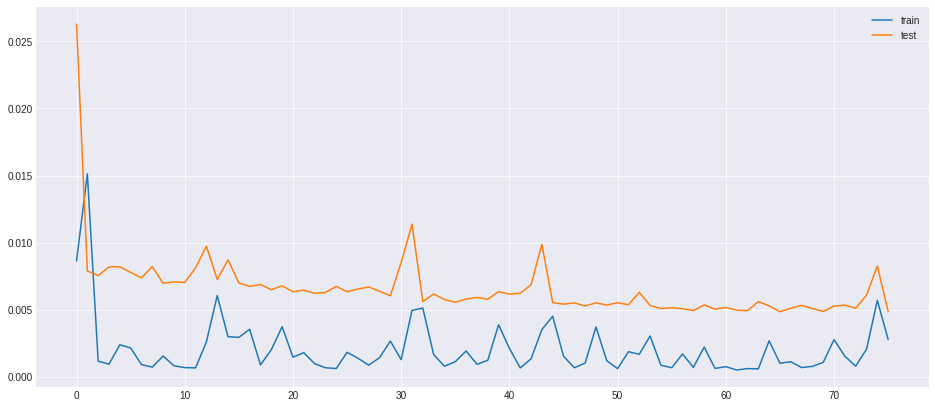

In [68]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# LSTM Predictions using testX and plotting line graph against Actual testY

Due to scaling step done earlier with MinMaxScaler the predicted scale is between 0 and 1. 
Now, I need to transfer this scale to the original data scale (real value). for example:[0.58439621 0.58439621 0.58439621 ... 0.81262134 0.81262134 0.81262134], the pred answer transfer to :[250 100 50 60 .....]
So here I am going to use `inverse_transform` to Scale back the data to the original representation.

In [69]:
# Transformation to original form and making the predictions

# predicted_btc_price_test_data = regressor.predict(testX)
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)

predicted_btc_price_test_data = scaler_test.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))

test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))

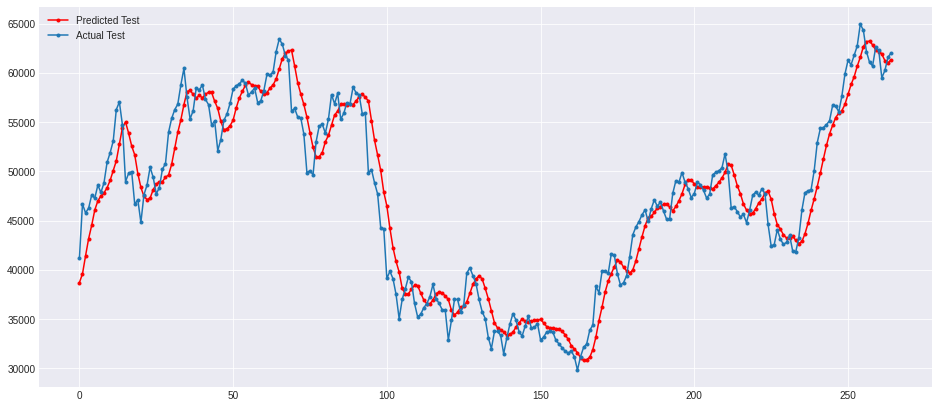

In [70]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()
plt.show()

# LSTM Prediction using trainX and plotting line graph against Actual trainY

In [71]:
# Transformation to original form and making the predictions

predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)

predicted_btc_price_train_data = scaler_train.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))

train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))

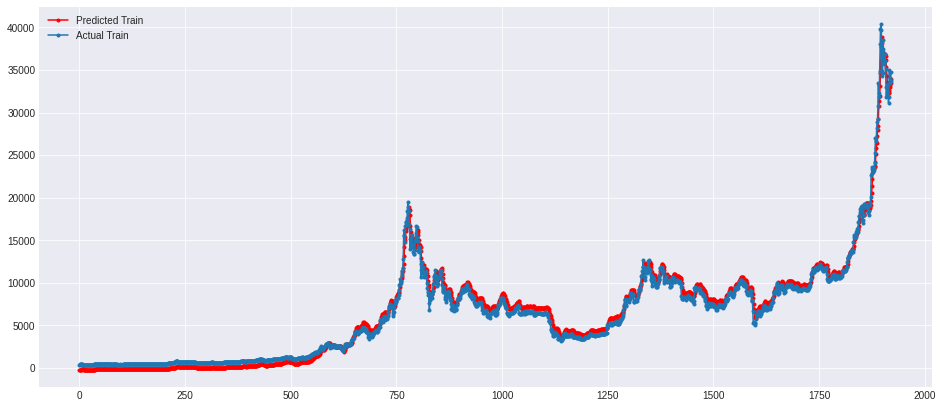

In [72]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Train')

plt.plot(train_actual, marker='.', label='Actual Train')

plt.legend()
plt.show()

# RMSE - Test Data

In [77]:
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_btc_price_test_data))

print('Test RMSE: %.3f' % rmse_lstm_test)

from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(predicted_btc_price_test_data, test_actual)
print('Test R squareed: %.3f' % coefficient_of_dermination)
# With 2 Layers + Dropout + lookback=5 => I got - Test RMSE: 1666.162  => This seems best


Test RMSE: 2446.923
Test R squareed: 0.925


# RMSE - Train Data

In [81]:
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))
from sklearn.metrics import r2_score

print('Test RMSE: %.3f' % rmse_lstm_train)

coefficient_of_dermination2 = r2_score(predicted_btc_price_train_data, train_actual)
print('Test R-squared: %.3f' % coefficient_of_dermination2)

# With 2 Layers + Dropout + lookback=5 => I got - Test RMSE: 1047.916  => This seems best

Test RMSE: 742.828
Test R-squared: 0.986
